Imports and Worksheet Creation

In [39]:
import pandas as pd
import math
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from fuzzywuzzy import process
from scipy.stats import norm

WorkSheet Creation

In [ ]:
#define file names
UncleanData = "amazon_laptop_2023.xlsx"
CleanData = "amazon_laptop_2023_cleaned.xlsx"
#read data from Excel file
df = pd.read_excel(UncleanData)

Custom Functions

In [ ]:
def concatenate_brand_model(Features):
    #establish columns
    brand = str(Features['brand'])
    model = str(Features['model'])
    #check brand isn't already in model
    if brand not in model:
        return brand + ' ' + model
    else:
        return model 
    
def process_storage(value):
    #check if value contains unit
    if type(value) == str:

        #remove unit
        vals = value.split(' ')
        vals[0] = float(vals[0])

        #check if value needs converting to gb and return converted value
        if (vals[1] == 'tb'):
            return int(vals[0]) * 1000
        
        #if no conversion needed return value
        return str(round(vals[0]))
    return str(value)

def regression_with_price(df, target):
    #select datapoints with values for price to train regression model
    X = df.dropna(subset=[target])[['price']]
    y = df.dropna(subset=[target])[target]

    #train model
    tree_model = DecisionTreeRegressor()
    tree_model.fit(X, y)

    #identify target records for regression
    X_missing = df[df[target].isna()][['price']]

    #predict values
    predicted_values = tree_model.predict(X_missing)
    return predicted_values

def regression_with_price_test(df, target):
    #select datapoints with values for 'price' to train the regression model
    X = df.dropna(subset=[target])[['price']]
    y = df.dropna(subset=[target])[target]

    #split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=None)

    #train model
    tree_model = DecisionTreeRegressor()
    tree_model.fit(X_train, y_train)

    #identify target records for regression
    X_missing = df[df[target].isna()][['price']]

    #predict values
    predicted_values = tree_model.predict(X_missing)

    #evaluate the model on the testing set
    y_pred_test = tree_model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred_test)
    r2 = r2_score(y_test, y_pred_test)

    print(f'Mean Squared Error for {target}: {mse}')
    print(f'R-squared on {target}: {r2}\n\n')

    return predicted_values

def rating_regression_test(df):
    #tests accuracy of decision tree model for prediction of rating values by MSE and R-squared value

    test = df.copy()
    test = test.dropna(subset=['rating'])

    #columns regressed on
    X = test[['screen_size', 'harddisk', 'ram', 'OS', 'graphics']]
    y = test['rating']

    #split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    #preprocess categorical features
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(handle_unknown='ignore'), ['OS', 'graphics'])
        ],
        remainder='passthrough'
    )

    #transform tree with categorical values
    X_train_encoded = preprocessor.fit_transform(X_train)
    X_test_encoded = preprocessor.transform(X_test)

    #train model with data
    decision_tree_model = DecisionTreeRegressor()
    decision_tree_model.fit(X_train_encoded, y_train)

    #make predictions and evaluate performance
    y_pred = decision_tree_model.predict(X_test_encoded)
    y_pred_rescaled = (y_pred - np.min(y_pred)) / (np.max(y_pred) - np.min(y_pred)) * 5

    mse = mean_squared_error(y_test, y_pred_rescaled)
    r2 = r2_score(y_test, y_pred_rescaled)

    print(f'Mean Squared Error: {mse}')
    print(f'R-squared: {r2}')

def regression_on_price_test(df):
    #function to test the use of a regression model for the prediction of the price values by evaluating the MSE and R-sqaured value

    #take copies of df to ensure original values unchanged
    test = df.copy()
    test = test.dropna(subset=['price'])

    #select columns for data
    X = test[['screen_size', 'harddisk', 'ram', 'OS', 'graphics']]
    y = test['price']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    #preprocess categorical features
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(handle_unknown='ignore'), ['OS', 'graphics'])
        ],
        remainder='passthrough'
    )

    X_train_encoded = preprocessor.fit_transform(X_train)
    X_test_encoded = preprocessor.transform(X_test)

    #train model with data
    decision_tree_model = DecisionTreeRegressor()
    decision_tree_model.fit(X_train_encoded, y_train)

    #make predictions and evaluate performance
    y_pred = decision_tree_model.predict(X_test_encoded)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f'Mean Squared Error: {mse}')
    print(f'R-squared: {r2}')

def regression_on_price(df):

    #filter df to get training data for regression model and prediction data
    train_data = df.dropna(subset=['price'])
    predict_data = df[df['price'].isna()]
    X_train = train_data[['screen_size', 'harddisk', 'ram', 'OS', 'graphics']]
    y_train = train_data['price']
    X_predict = predict_data[['screen_size', 'harddisk', 'ram', 'OS', 'graphics']]

    #preprocess categorical features
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(handle_unknown='ignore'), ['OS', 'graphics'])
        ],
        remainder='passthrough'
    )

    X_train_encoded = preprocessor.fit_transform(X_train)
    X_predict_encoded = preprocessor.transform(X_predict)

    #train model with data
    decision_tree_model = DecisionTreeRegressor()
    decision_tree_model.fit(X_train_encoded, y_train)

    #make predictions for records without prices rounded to 2dp
    predicted_prices = decision_tree_model.predict(X_predict_encoded).round(2)

    #reinsert data into df
    df.loc[df['price'].isna(), 'price'] = predicted_prices

    return df


def cpu_shrink(cpu_column):
    #initial set of allowed values
    allowed_cpus = ['core m', 'core i3', 'core i5', 'core i7', 'core i9', 'ryzen 3', 'ryzen 5', 'ryzen 7', 'ryzen 9', 'celeron', 'ryzen r series']


    for i in range(len(cpu_column)):
        value = cpu_column.iloc[i]

        #maintain unknown values
        if (value == "unknown") or (value == "nan") or (value == "others"):
            cpu_column.iat[i] = "nan"
            continue
        
        #run fuzzy string matching on value
        result = process.extractOne(str(value), allowed_cpus)
        match_value, score = result

        #if matching confidence less than 90% insert value into set of allowed cpus, otherwise use matched value.
        if score < 90:
            allowed_cpus.append(value)
            cpu_column.iat[i] = value
        else:
            cpu_column.iat[i] = match_value

    #return shrunk column
    return cpu_column

def os_shrink(os_column):
    #initial set of allowed values
    allowed_os = ['windows 7', 'windows 8', 'windows 10 home', 'windows 10 pro', 'windows 11 home', 'windows 11 pro', 'mac os', 'chrome os']


    for i in range(len(os_column)):
        value = os_column.iloc[i]

        #maintain unknown values
        if (value == "unknown") or (value == "nan") or (value == "others"):
            os_column.iat[i] = "nan"
            continue

        #run fuzzy string matching on value
        result = process.extractOne(str(value), allowed_os)
        match_value, score = result

        os_column.iat[i] = match_value

    #return shrunk column
    return os_column

def special_shrink(special_column):
    #initial set of allowed values
    allowed_special = ['wifi', 'bluetooth', 'anti glare', 'fingerprint reader', 'backlit keyboard', 'hd audio', 'stylus', 'security slot', 'memory card slot','bezel', 'corning gorilla glass']


    for i in range(len(special_column)):
        inp = []

        #leave unknown values as an empty set of features
        if (str(special_column.iloc[i]) == "nan"):
            special_column.iat[i] = []
            continue

        #convert string into array of features
        values = special_column.iloc[i].split(',')

        for value in values:
            value = value.strip()

            #handle obvious pitfalls i.e. n/a values, sentences which contain commas, and empty values
            if (value == "information not available"):
                special_column.iat[i] = []
                break
            elif (value.count(" ") > 3) or (value == ""):
                continue
            
            #run fuzzy string matching on value
            result = process.extractOne(str(value), allowed_special)
            match_value, score = result

            #if matching confidence less than 90% insert value into set of allowed values(unless one of the major outliers that already matches a value in the allowed array), otherwise use matched value and add to the features array for that record.
            if score < 90:
                if(value == "backlit kb"):
                    inp.append("backlit keyboard")
                elif(value == "fingerprint sensor"):
                    inp.append("fingerprint reader")
                elif(value == 'pen'):
                    inp.append("stylus")
                else:
                    allowed_special.append(value)
                    inp.append(value)
            else:
                inp.append(match_value)

        #set value for that record as array of identified features
        special_column.iat[i] = inp
    
    #return shrunk and reformated column
    return special_column

def special_clean(special_column):
    #function to remove features which have cardinality one and are therefore outliers

    values = {}

    for i in range(len(special_column)):

        for feature in special_column.iloc[i]:
            #add index of record to associated feature in dictionary
            if feature in values:
                values[feature].append(i)
            else:
                values[feature] = [i]
    
    #remove any features that only appear once from the record that they appear
    for x in values.keys():
        if len(values[x]) == 1:
            special_column.iloc[values[x][0]].remove(x)

    #return cleaned column
    return special_column

def combine_graphics(Features):
    #define columns
    coprocessor = str(Features['graphics_coprocessor'])
    graphics = str(Features['graphics'])

    if coprocessor != "nan":

        #check whether coprocessor column incorrectly used to declare integrated graphics
        if (coprocessor == "intel") or (coprocessor == "embedded"):
            return 'integrated'
        
        #otherwise use dedicated card
        return coprocessor
    
    #return the integrated graphics declared in the 'graphics' column or assume laptop uses integrated graphics
    elif (graphics != "nan"):
        return graphics
    else:
        return "integrated"

def graphics_shrink(graphics_column):
    #initial set of allowed values
    processors = ['integrated']

    for i in range(len(graphics_column)):
        value = str(graphics_column.iloc[i])
        if value == "nan":
            graphics_column.iat[i] = "integrated"
            continue

        #run fuzzy string matching on value
        result = process.extractOne(value, processors)
        match_value, score = result

        #if matching confidence less than 90% insert value into set of allowed cpus, otherwise use matched value.
        if score < 90:
            processors.append(value)
            graphics_column.iat[i] = value
        else:
            graphics_column.iat[i] = match_value

    #return shrunk column
    return graphics_column
    
def round_to_power_of_2(x, max):
    nearest = pow(2, round(math.log(x, 2)))
    if nearest > max:
        return max
    else:
        return nearest

Cleaning processes

In [ ]:
#delete cpu_speed and color column
df = df.drop('cpu_speed', axis=1)
df = df.drop('color', axis=1)

#remove whitespace and decapitalise all strings
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].str.strip()
        df[col] = df[col].str.lower()

#remove unnecessary keyword and rows without specified model
df = df.dropna(subset=['model'])
df.drop(df[df['model'].str.lower() == 'nan'].index, inplace=True)

#convert all storage to gb, remove strings from screen_size, ram, and harddisk, convert all to floats
df['harddisk'] = df['harddisk'].apply(process_storage)
for col in ['screen_size', 'ram', 'harddisk', 'price']:
    df[col] = df[col].str.replace(r'[^0-9.]', '', regex=True)
    df[col] = pd.to_numeric(df[col], errors='coerce')

#fill screensize unknowns with predictions from scikit decision tree regression model and round all screen sizes to 1 decimal place.
df.loc[df['screen_size'].isna(), 'screen_size'] = regression_with_price(df, 'screen_size')
df['screen_size'] = df['screen_size'].round(1)

#fill ram and harddisk values with average and round all ram and harddisk values to nearest power of two in accordance with storage standards
ram_mean = df['ram'].mean()
df['ram'] = df['ram'].fillna(ram_mean)
df['ram'] = df['ram'].apply(lambda x: round_to_power_of_2(x, max=32))

harddisk_mean = df['harddisk'].mean()
df['harddisk'] = df['harddisk'].fillna(harddisk_mean)
df['harddisk'] = df['harddisk'].apply(lambda x: round_to_power_of_2(x, max=2048))


#remove model duplicates, then merge the brand and model columns
df = df.drop_duplicates(subset=['model'])
df['model'] = df.apply(concatenate_brand_model, axis=1)
df = df.drop('brand', axis=1)

#use custom string matching algorithm to shrink the number of distinct values by standardising similar entries
df['cpu'] = cpu_shrink(df['cpu'])

#shrink number of possible OS values with fuzzy string matching
df['OS'] = os_shrink(df['OS'])

#change os to be one of the three main ones by fuzzy string matching
df['special_features'] = df['special_features'].str.replace('&',',')
df['special_features'] = special_shrink(df['special_features'])
df['special_features'] = special_clean(df['special_features'])

#combine graphics and graphics_coprocessor columns, where laptops with non integrated graphics have the card specified in the graphics column
df['graphics'] = df.apply(combine_graphics, axis=1)

#use custom string matching algorithm to shrink the number of distinct values by standardising similar entries
df['graphics'] = graphics_shrink(df['graphics'])

df = df.drop('graphics_coprocessor', axis=1)

# find mean of ratings column and fill all NaN values with this value
mean = df['rating'].mean().round(1)
df['rating'] = df['rating'].fillna(mean)

#remove all records with rating value less than the mean
df = df[df['rating'] >= mean]

#use decision tree regression to predict values for records with NaN for price
df = regression_on_price(df)

#drop all records with price greater than 1500 for Q2
df = df[df['price'] <= 1500]

#drop all records without a cpu listing, this is too important to be omitted and cannot accurately be predicted given current data
df = df.dropna(subset=['cpu'])
df.drop(df[df['cpu'].str.lower() == 'nan'].index, inplace=True)


Printing Dataframe

In [ ]:
print(df)

Saving to New Excel Spreadsheet

In [ ]:
df.to_excel(CleanData, index=False)

Open Cleaned Data

In [ ]:
CleanData = "amazon_laptop_2023_cleaned.xlsx"
# Read the data from the Excel file
stand_df = pd.read_excel(CleanData)

Initialise dictionary of relative scores of CPUs using effective CPU speed index [of median CPU for a given family if applicable]

information from: https://cpu.userbenchmark.com/ , https://versus.com/en , https://www.cpu-monkey.com/en/

In [ ]:
CPU_scores = {"core i7": 0.733, "core i5" : 0.648, "core i3" : 0.552, "core i9" : 0.997, "amd r series" : 0.538, "ryzen 5" : 0.771, "ryzen 7" : 0.881, "1.2ghz cortex a8 processor" : 0.301, "intel mobile cpu" : 0.478, "apple m1" : 0.967, "snapdragon" : 0.705, "mediatek mt8183" : 0.360, "celeron" : 0.212, "intel atom" : 0.192, "pentium" : 0.453, "mediatek_mt8127" : 0.046, "atom z8350" : 0.214, "athlon" : 0.401, "core m" : 0.380, "ryzen 3" : 0.74, "amd a4" : 0.340, "mediatek helio p60t" : 0.594, "amd kabini a6-5200m quad core" : 0.304, "core_m" : 0.380}


Initialise dictionary of relative scores of GPUs using effective GPU speed index

information from: https://www.cpu-monkey.com/en/, https://www.notebookcheck.net/, https://cpu.userbenchmark.com/

In [ ]:
GPU_scores = {"intel iris xe graphics" : 0.141, "integrated" : 0.141, "amd radeon graphics" : 0.212, "nvidia geforce mx250" : 0.137, "intel uhd graphics" : 0.052, "dedicated" : 0.141, "nvidia geforce rtx 3050 ti 4gb gddr6" : 0.608, "rtx t600" : 0.221, "xps9300-7909slv-pus" : 0.055, "amd radeon 680m" : 0.181, "nvidia geforce rtx 4050" : 0.961, "rtx 3060" : 0.899, "intel hd" : 0.029, "nvidia quadro t1000" : 0.241, "nvidia geforce gtx 1660" : 0.650, "iris x graphics" : 0.141, "rtx a3000" : 0.620, "nvidia rtx a1000" : 0.300, "intel xe" : 0.141, "amd radeon rtx 3070" : 1.48, "intel iris plus" : 0.092, "t550" : 0.169, "nvidia geforce rtx 2070 super" : 0.976, "amd radeon r5" : 0.021, "mediatek" : 0.141, "powervr gx6250" : 0.318, "amd athlon silver" : 0.141, "amd radeon vega 3" : 0.046, "adreno 618" : 0.014, "2gb nvidia geforce mx230 graphics" : 0.104, "nvidia geforce rtx 3080 ti" : 1.33, "nvidia t600" : 0.221}

Generic Feature Scaling Functions and Mapping Function for CPU/GPU

In [ ]:
def min_max_scale(data):
    #scale data to be between 0-1
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def log_scale(data):
    #log values to reduce affect of outliers
    data = np.log(data)

    #scale data to be between 0-1
    return min_max_scale(data)

def card_replace(column, dict):
    #for each column, map processor to numerical performance
    column = column.map(dict)
    return column

Create New Reconfigured Dataframe so all Columns can be Numerically Considered Based on Z-Scores

In [ ]:
#drop rating column as data is unreliable for scoring
stand_df = stand_df.drop(["rating"], axis=1)

#convert processing card values with associated numerical performance
for x in [["cpu", CPU_scores],["graphics", GPU_scores]]:
    stand_df[x[0]] = card_replace(stand_df[x[0]], x[1])

#min-max scale processor values, useful to allow outliers to skew scale as most laptops will use low performance cards
for x in ["cpu","graphics","screen_size"]:
        stand_df[f'{x}_score'] = min_max_scale(stand_df[x])

#min-max scale price, and invert score (want higher score to indicate lower price)
stand_df["price_score"] = 1 - min_max_scale(stand_df["price"])

#use log scaling as values appear in order of magnitude of each other
for x in ["harddisk", "ram"]:
        stand_df[f'{x}_score'] = log_scale(stand_df[x])

Calculate New Dataframe With Z-Scores

In [ ]:
def calculate_scores(df,features={}, os={}, screen_weight=1, harddisk_weight=1, cpu_weight=1, ram_weight=1, graphics_weight=1, price_weight=1):
    #copy new DataFrame for added scores columns
    scores_df = df.copy()

    #calculate overall score from individual weights
    scores_df['score'] = (
        screen_weight * scores_df['screen_size_score'] +
        harddisk_weight * scores_df['harddisk_score'] +
        cpu_weight * scores_df['cpu_score'] +
        ram_weight * scores_df['ram_score'] +
        graphics_weight * scores_df['graphics_score'] +
        price_weight * scores_df['price_score']
    )
    
    #increase score for special features
    for feature, value in features.items():
        scores_df['score'] += value * scores_df['special_features'].apply(lambda x: int(feature in x))

    #increase score for os
    for os, value in os.items():
        scores_df['score'] += value * scores_df['OS'].apply(lambda x: int(os in x))


    return scores_df

#calculate score and sort dataframe by scores before storing
stand_df = calculate_scores(stand_df)
stand_df = stand_df.sort_values(by='score', ascending=False)
stand_df.to_excel("scored-df.xlsx", index=False)

Import Normalised Dataframe

In [40]:
stand_df = pd.read_excel("scored-df.xlsx")

Import Modules for Plotting Data

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline

Define Function to build and Save Plot for Score Distribution

In [52]:
def build_and_save_distribution(column, df):
    #generate bins for scores
    bins = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1]

    #discretize data into specified bins
    df[f'{column}_bucket'] = pd.cut(df[column], bins=bins, labels=['0-0.05','0.05-0.1','0.1-0.15','0.15-0.2','0.2-0.25','0.25-0.3','0.3-0.35','0.35-0.4','0.4-0.45','0.45-0.5','0.5-0.55','0.55-0.6','0.6-0.65','0.65-0.7','0.7-0.75','0.75-0.8','0.8-0.85','0.85-0.9','0.9-0.95','0.95-1',])

    #create bar chart using Seaborn
    sns.set(style="whitegrid")
    plt.figure(figsize=(12, 6))

    chart = sns.countplot(x=f'{column}_bucket', data=df, palette='viridis')

    #get bar heights and midpoints
    bar_heights = [p.get_height() for p in chart.patches]
    bar_midpoints = [(p.get_x() + (p.get_width() / 2)) for p in chart.patches]
    
    #use cubic spline to create a smooth function passing through the midpoints
    cs = CubicSpline(bar_midpoints, bar_heights, bc_type=((2, 0.0), (2, 0.0)))

    #generate x values for the smooth curve
    x_smooth = np.linspace(min(bar_midpoints), max(bar_midpoints), 1000)

    #plot curve
    plt.plot(x_smooth, cs(x_smooth), color='orange', label='Distribution Estimate', linewidth=2)

    #rotate x-axis labels so visible
    chart.set_xticklabels(chart.get_xticklabels(), rotation=75)

    #set labels, title, and fit so as to not crop out data
    plt.xlabel('Scores')
    plt.ylabel('Count')
    plt.title(f'{column} Score Distribution')
    plt.tight_layout()
    
    #save and show figure
    plt.savefig(f'{column}_distribution.pdf')
    plt.legend()  # Show legend with smooth curve label
    plt.show()

Run for Z-Score Normalised Features

C:\Users\lukep\AppData\Local\Temp\ipykernel_12572\523200705.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  chart = sns.countplot(x=f'{column}_bucket', data=df, palette='viridis')
C:\Users\lukep\AppData\Local\Temp\ipykernel_12572\523200705.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  chart.set_xticklabels(chart.get_xticklabels(), rotation=75)


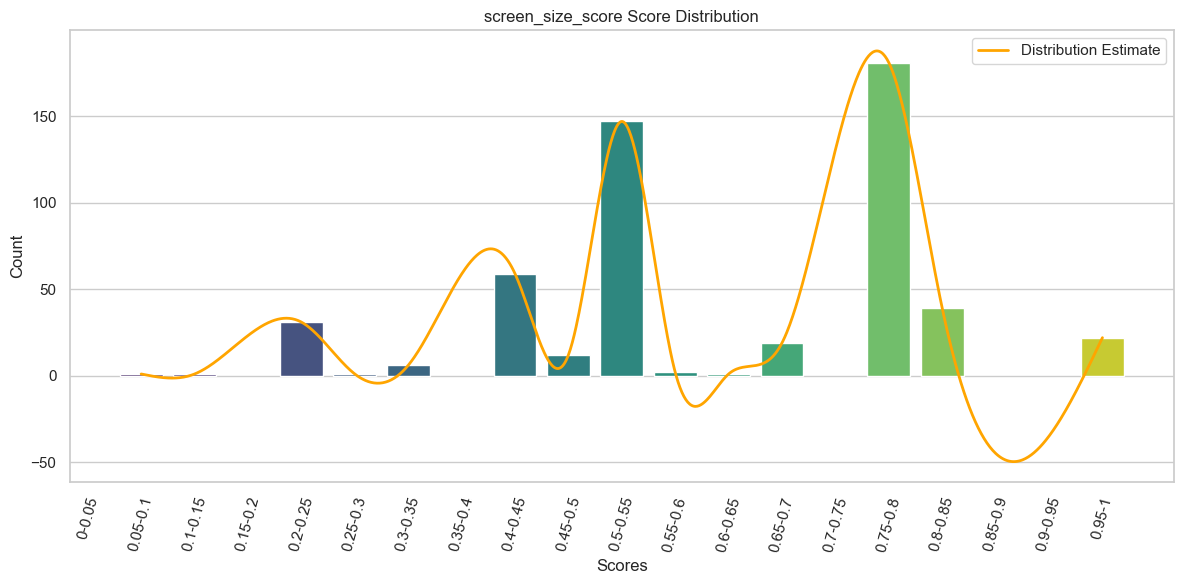

C:\Users\lukep\AppData\Local\Temp\ipykernel_12572\523200705.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  chart = sns.countplot(x=f'{column}_bucket', data=df, palette='viridis')
C:\Users\lukep\AppData\Local\Temp\ipykernel_12572\523200705.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  chart.set_xticklabels(chart.get_xticklabels(), rotation=75)


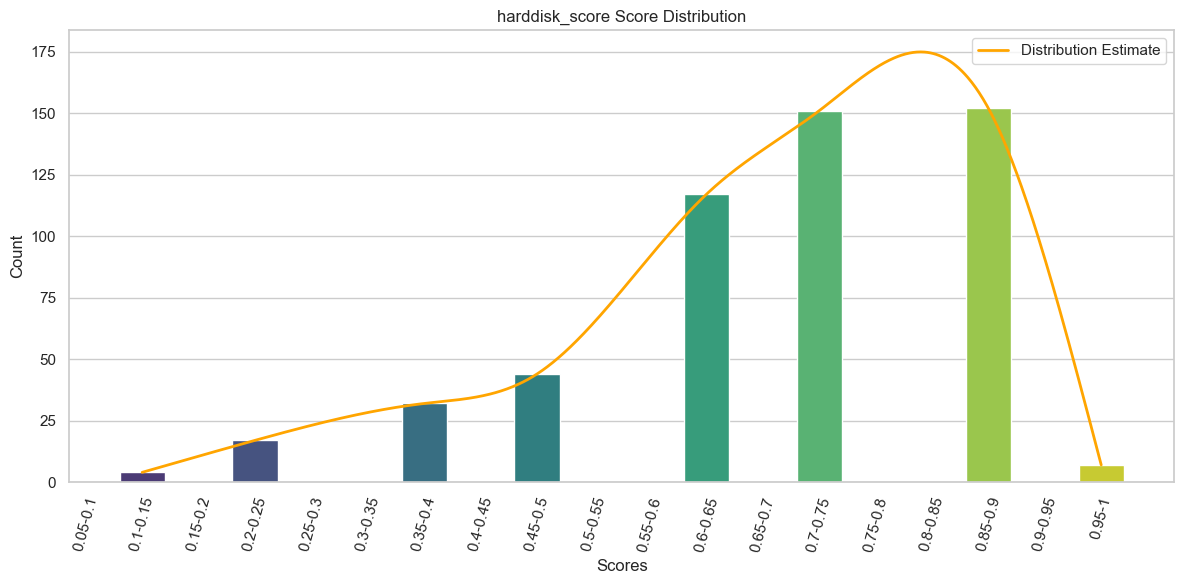

C:\Users\lukep\AppData\Local\Temp\ipykernel_12572\523200705.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  chart = sns.countplot(x=f'{column}_bucket', data=df, palette='viridis')
C:\Users\lukep\AppData\Local\Temp\ipykernel_12572\523200705.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  chart.set_xticklabels(chart.get_xticklabels(), rotation=75)


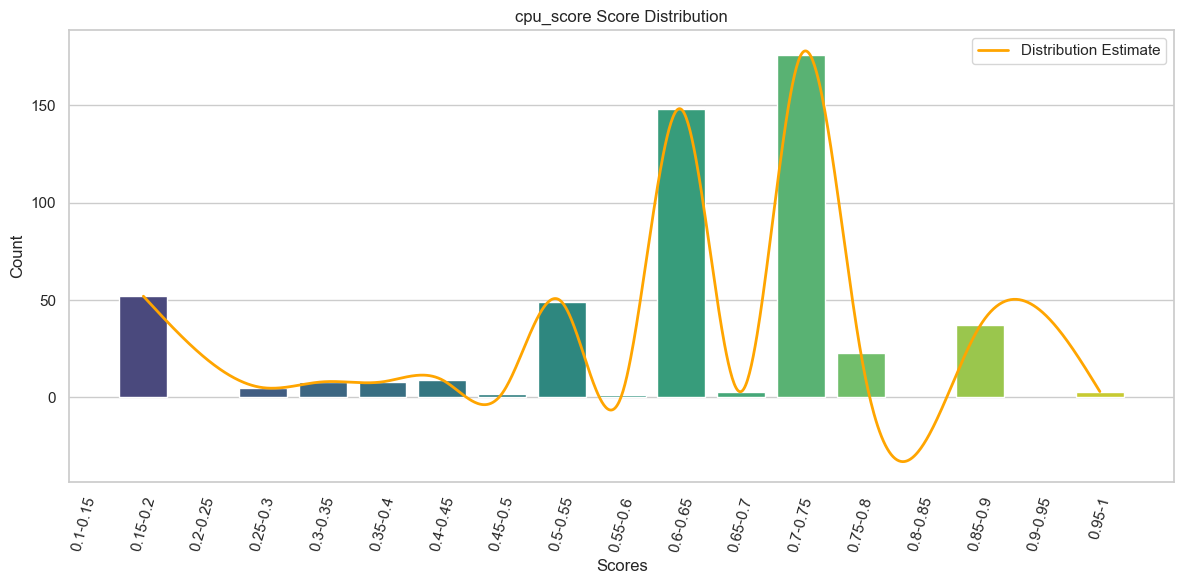

C:\Users\lukep\AppData\Local\Temp\ipykernel_12572\523200705.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  chart = sns.countplot(x=f'{column}_bucket', data=df, palette='viridis')
C:\Users\lukep\AppData\Local\Temp\ipykernel_12572\523200705.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  chart.set_xticklabels(chart.get_xticklabels(), rotation=75)


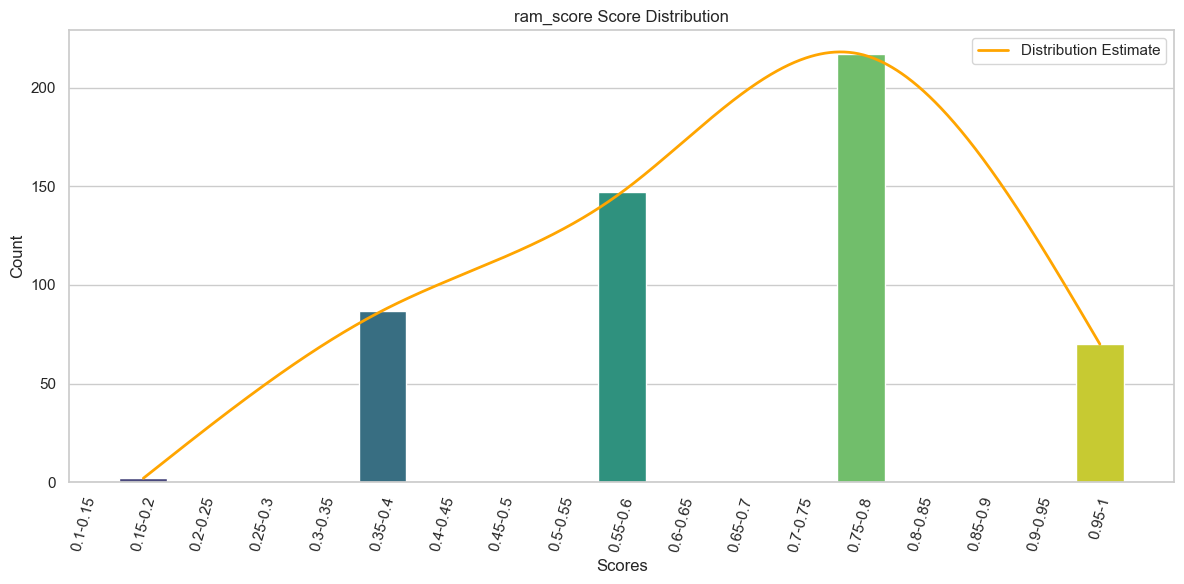

C:\Users\lukep\AppData\Local\Temp\ipykernel_12572\523200705.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  chart = sns.countplot(x=f'{column}_bucket', data=df, palette='viridis')
C:\Users\lukep\AppData\Local\Temp\ipykernel_12572\523200705.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  chart.set_xticklabels(chart.get_xticklabels(), rotation=75)


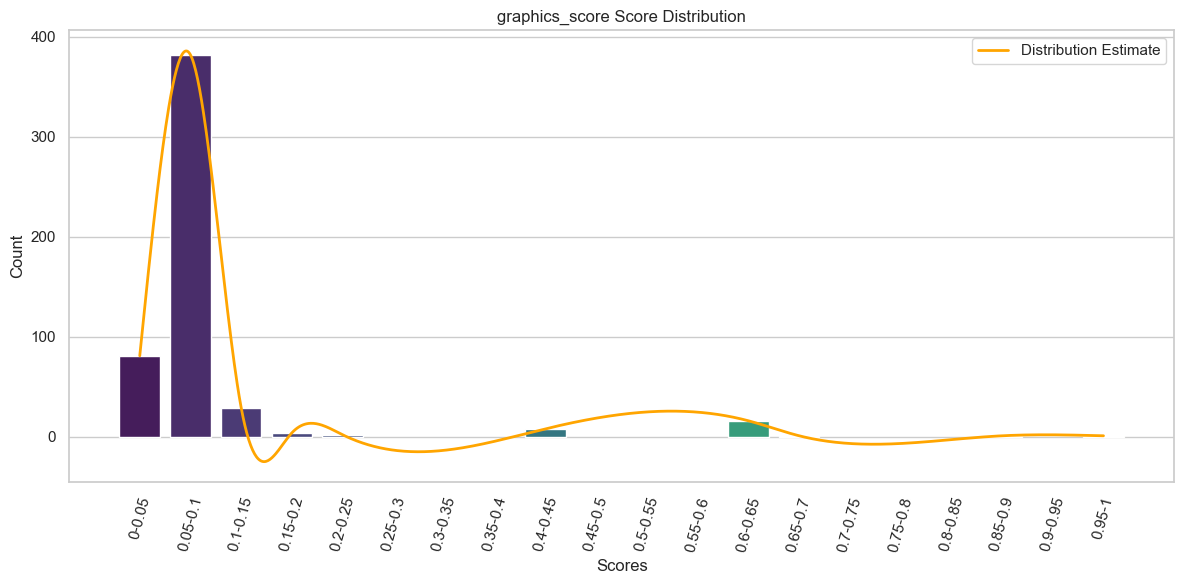

C:\Users\lukep\AppData\Local\Temp\ipykernel_12572\523200705.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  chart = sns.countplot(x=f'{column}_bucket', data=df, palette='viridis')
C:\Users\lukep\AppData\Local\Temp\ipykernel_12572\523200705.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  chart.set_xticklabels(chart.get_xticklabels(), rotation=75)


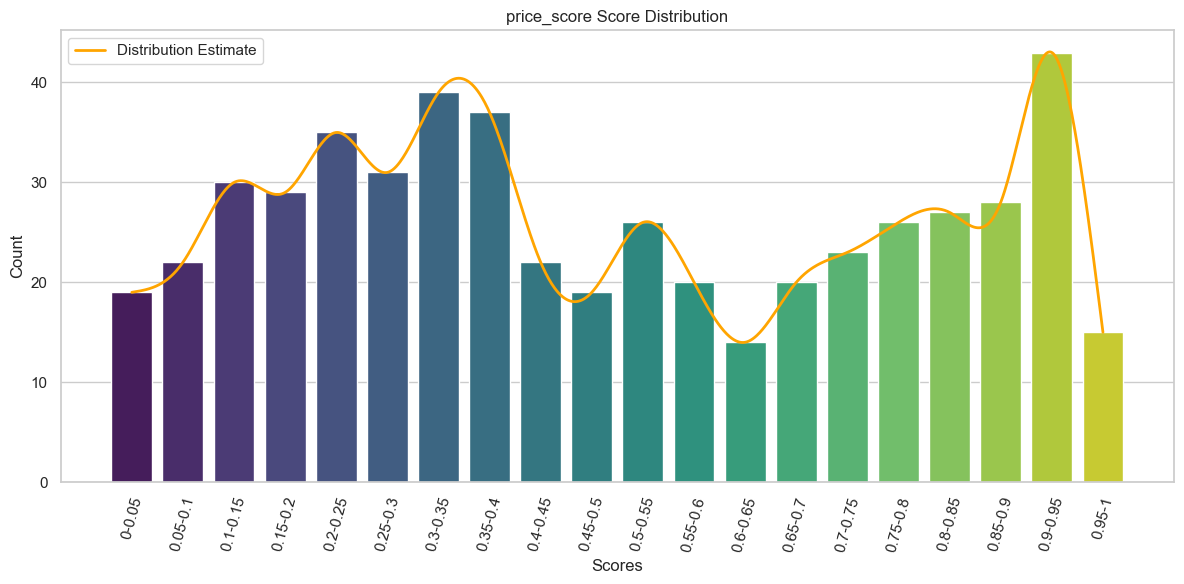

In [53]:
for col in ["screen_size_score", "harddisk_score", "cpu_score", "ram_score", "graphics_score", "price_score"]:
    build_and_save_distribution(col, stand_df)

Run Custom Configuration for Overall Scores (not z-score normalised)

C:\Users\lukep\AppData\Local\Temp\ipykernel_12572\1908144111.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  chart = sns.countplot(x='score_bucket', data=stand_df, palette='viridis')
C:\Users\lukep\AppData\Local\Temp\ipykernel_12572\1908144111.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  chart.set_xticklabels(chart.get_xticklabels(), rotation=75, horizontalalignment='right')


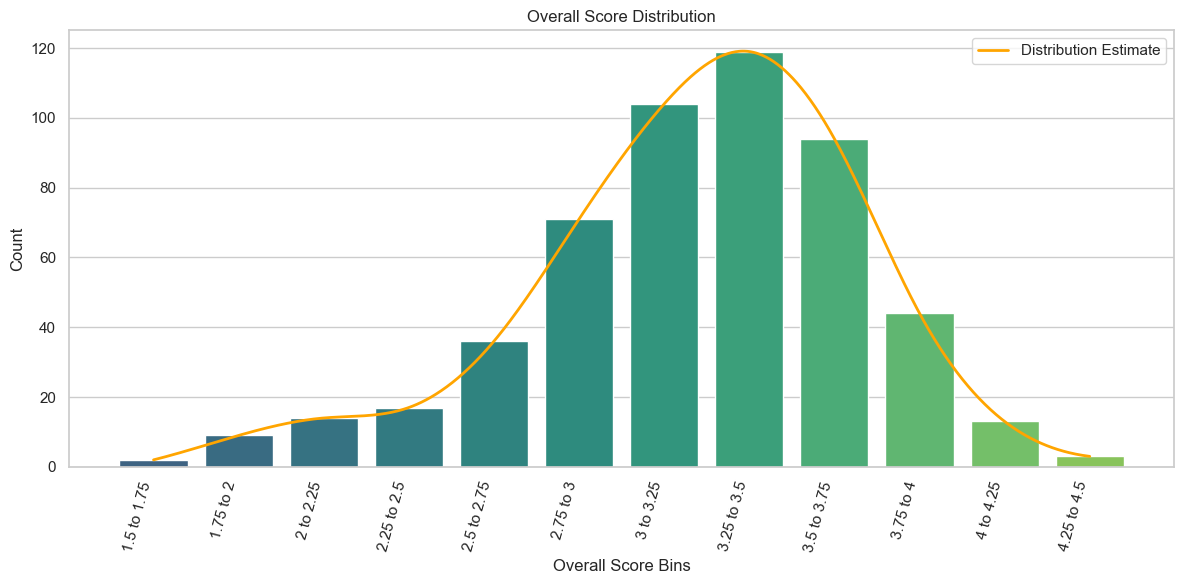

In [56]:
bins = [0, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3, 3.25, 3.5, 3.75, 4, 4.25, 4.5, 4.75, 5, 5.25]

#discretize data into specified bins
stand_df['score_bucket'] = pd.cut(stand_df['score'], bins=bins, labels = ['0 to 0.25', '0.25 to 0.5', '0.5 to 0.75', '0.75 to 1', '1 to 1.25', '1.25 to 1.5', '1.5 to 1.75', '1.75 to 2', '2 to 2.25', '2.25 to 2.5', '2.5 to 2.75', '2.75 to 3', '3 to 3.25', '3.25 to 3.5', '3.5 to 3.75', '3.75 to 4', '4 to 4.25', '4.25 to 4.5', '4.5 to 4.75', '4.75 to 5', '5 to 5.25'])

sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
chart = sns.countplot(x='score_bucket', data=stand_df, palette='viridis')

# Get the bar heights and midpoints
bar_heights = [p.get_height() for p in chart.patches]
bar_midpoints = [(p.get_x() + p.get_width() / 2.) for p in chart.patches]

# Use cubic spline to create a smooth function passing through the midpoints
cs = CubicSpline(bar_midpoints, bar_heights)

# Generate x values for the smooth curve
x_smooth = np.linspace(min(bar_midpoints), max(bar_midpoints), 1000)

# Plot the smooth curve
plt.plot(x_smooth, cs(x_smooth), color='orange', label='Distribution Estimate', linewidth=2)

# Rotate x-axis labels for better readability
chart.set_xticklabels(chart.get_xticklabels(), rotation=75, horizontalalignment='right')

# Set plot labels and title
plt.xlabel('Overall Score Bins')
plt.ylabel('Count')
plt.title('Overall Score Distribution')
plt.tight_layout()

plt.savefig('score_distribution.pdf')
plt.legend()
plt.show()

Find Best Laptop for Video-Editor and Travelling Business-man

In [57]:
Editor_df = calculate_scores(df=stand_df, screen_weight=1,harddisk_weight=1.6,cpu_weight=2,ram_weight=2,graphics_weight=2,price_weight=0.5)
Editor_df = Editor_df.sort_values(by='score', ascending=False)
Editor_df.to_excel("Editor_recommendations.xlsx", index=False)


Business_df = calculate_scores(df=stand_df, features={"backlit keyboard" : 0.3, "lightweight" : 0.3, "corning gorilla glass" : 0.2, "spill resistant" : 0.2, "anti glare" : 0.2}, os={"windows 11 pro": 0.4, "windows 10 pro" : 0.35, "mac os" : 0.3}, screen_weight=-0.3,harddisk_weight=1,cpu_weight=1,ram_weight=1,graphics_weight=1,price_weight=1.5)
Business_df = Business_df.sort_values(by='score', ascending=False)
Business_df.to_excel("Business_recommendations.xlsx", index=False)
print(Business_df)

                      model  screen_size  harddisk    cpu  ram  \
117         acer chromebook         11.6      1024  0.538   32   
36       hp elitebook 840g1         14.0      1024  0.733   16   
43              hp notebook         14.0      1024  0.740   16   
139     hp elitebook 840 g6         14.0       256  0.648   16   
163  rokc thinkpad l13 yoga         13.3      1024  0.733   16   
..                      ...          ...       ...    ...  ...   
485    hp envy  13-aq0005nr         13.3       256  0.733    8   
524           samsung 11.6"         11.6        16  0.192    2   
444     lg 15zb90q-v.ars5u1         15.0       512  0.648    8   
515            hp elitebook         14.0      1024  0.301    1   
507          hp 659k2ut#aba         14.0         8  0.453    8   

                  OS                                   special_features  \
117        chrome os                               ['backlit keyboard']   
36    windows 10 pro                                     